In [4]:
import pandas as pd
data = pd.read_csv("bedload_dataset.csv")
data.describe()

,W,S,Q,U,H
count,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,43.311378,0.018194,145.828163,1.050431,0.795586
std,80.421656,0.017952,408.636948,0.547559,0.996045
min,0.600000,0.000110,0.010000,0.130000,0.060000
25%,5.455000,0.002300,1.100000,0.630000,0.280000
50%,8.530000,0.013100,3.200000,0.960000,0.390000
75%,18.400000,0.025000,20.100000,1.340000,0.870000
max,466.000000,0.085600,4559.010000,3.850000,14.000000


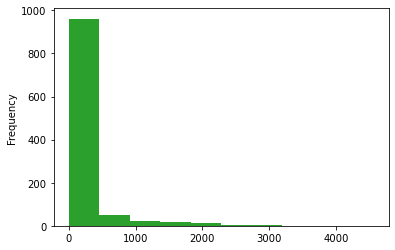

In [8]:
for column in data.columns:
    if not "morph" in str(column).lower():
        data[column].plot(kind='hist')

In [11]:
for column in data.columns:
    try:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = data[(data[column] < Q1 - 1.5 * IQR) | (data[column] > Q3 + 1.5 *IQR)]
        print("Outliners in column " + str(column) + ": " + str(outliers))
    except TypeError:
        print(f"Column '{column}' is not numeric.")

Outliners in column W:            W        S        Q     U     H   Morphology
0      65.23  0.00410   319.98  2.90  1.69  Riffle-pool
3     166.12  0.00068  1124.18  1.78  3.81  Riffle-pool
11     63.00  0.00250    90.30  1.70  0.86  Riffle-pool
20     53.00  0.00130    34.80  1.40  0.46  Riffle-pool
21    182.88  0.00092  2067.13  2.41  4.72  Riffle-pool
...      ...      ...      ...   ...   ...          ...
1059  288.00  0.00170  1580.00  2.00  2.80     Braiding
1060  108.00  0.00096   643.00  2.60  2.40     Braiding
1061  185.00  0.00120   595.00  1.80  1.80     Braiding
1062  102.00  0.00096   171.00  1.40  1.20     Braiding
1064  101.00  0.00044   260.00  1.50  1.80     Braiding

[239 rows x 6 columns]
Outliners in column S:         W       S     Q     U     H Morphology
254  0.71  0.0718  0.08  0.51  0.23  Plane Bed
255  0.71  0.0718  0.08  0.51  0.23  Plane Bed
258  0.71  0.0718  0.14  0.64  0.30  Plane Bed
292  0.71  0.0718  0.01  0.23  0.09  Plane Bed
303  0.70  0.0718  0.04

In [13]:
import scipy.stats as stats
import numpy as np
numeric_columns = data.select_dtypes(include=[np.number])

In [18]:
normality_results = {}
for column in numeric_columns:
    stat, p_value= stats.shapiro(numeric_columns[column])
    normality_results[column] = {"Statistic": stat, "p-value": p_value, "Normality": p_value > 0.05}

In [19]:
normality_results

{'W': {'Statistic': 0.5522581934928894,
  'p-value': 1.401298464324817e-45,
  'Normality': False},
 'S': {'Statistic': 0.8678439259529114,
  'p-value': 4.538365742468255e-29,
  'Normality': False},
 'Q': {'Statistic': 0.4087470769882202, 'p-value': 0.0, 'Normality': False},
 'U': {'Statistic': 0.9356546998023987,
  'p-value': 4.733041838910328e-21,
  'Normality': False},
 'H': {'Statistic': 0.6150405406951904,
  'p-value': 1.5974802493302915e-43,
  'Normality': False}}

In [20]:
import matplotlib.pyplot as plt

def create_qq_plots(df):
    for column in df.columns:
        #Drop missing values
        column_data = df[column].dropna()
        
        #Generate QQ plot
        plt.figure()
        stats.probplot(column_data, dist="norm", plot=plt)
        plt.title(f"QQ Plot for {column}")
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Sample Quantiles")
        plt.show()

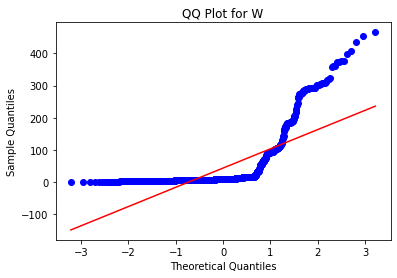

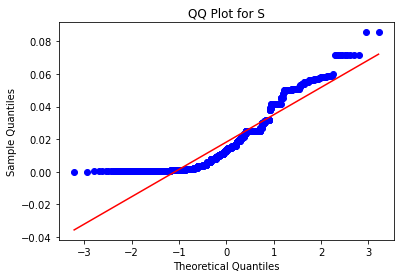

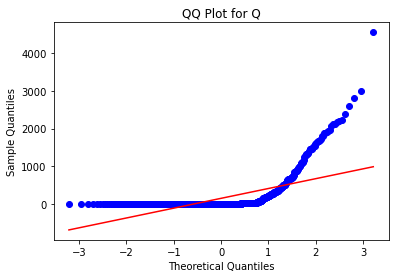

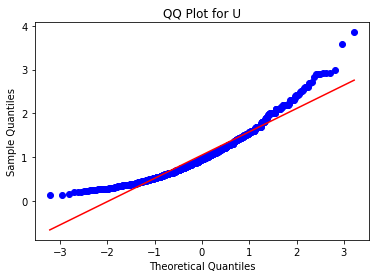

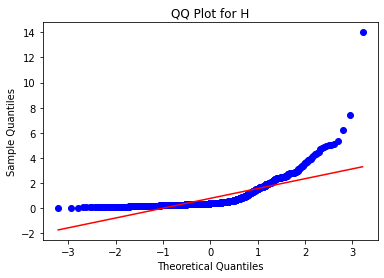

In [21]:
create_qq_plots(numeric_columns)

In [22]:
distributions = ['norm', 'lognorm', 'expon', 'gamma', 'weibull_min']

In [26]:
best_fit_results = {}

for column in numeric_columns:
    column_data = numeric_columns[column].dropna() #Removing Nans
    best_fit = {'distribution': None, 'p_value': 0}
    
    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        params = dist.fit(column_data)
        
        #Peform the Kolmogorov.Smirnov test
        ks_stat, p_value = stats.kstest(column_data, dist_name, args=params)
        
        #Keep track of the distribution with the highest p-value
        if p_value > best_fit['p_value']:
            best_fit = {'distribution': dist_name, 'p_value': p_value, 'params': params}
    
    best_fit_results[column] = best_fit

best_fit_results

{'W': {'distribution': 'lognorm',
  'p_value': 1.3281479862159963e-25,
  'params': (1.5020661549966676, 0.5466562176441883, 12.19514555485304)},
 'S': {'distribution': 'lognorm',
  'p_value': 7.560101424369426e-18,
  'params': (1.61168379026289, 4.413912845925009e-05, 0.007833012236740884)},
 'Q': {'distribution': 'lognorm',
  'p_value': 7.5066705228892e-17,
  'params': (2.602729339884881, 0.009439797821284762, 6.0684383175324434)},
 'U': {'distribution': 'gamma',
  'p_value': 0.9501777346713755,
  'params': (3.0373864872481873, 0.09089018249168254, 0.3159105378423672)},
 'H': {'distribution': 'lognorm',
  'p_value': 2.1632652065346276e-11,
  'params': (1.0176242593232163, 0.048290891105940925, 0.4295242325477308)}}

In [29]:
spearman_correlation = numeric_columns.corr(method='spearman')
print(spearman_correlation)

          W         S         Q         U         H
W  1.000000 -0.803452  0.926306  0.565058  0.815212
S -0.803452  1.000000 -0.778831 -0.387029 -0.767482
Q  0.926306 -0.778831  1.000000  0.763733  0.932169
U  0.565058 -0.387029  0.763733  1.000000  0.665300
H  0.815212 -0.767482  0.932169  0.665300  1.000000


# Homework
fitter package,
find best fitter to the data here
scipy needed

PCA = principal 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StadardScaler()
scaled_data = scaler.fit_transform(numeric_columns)
principal_components = pca.fit_transform(scaled_data)

look into the principal components and try to interprete them
plt.scatter(pca_df['PC1'], pca_df['PC2'])
try to interprete this plot and results

#create a dataframe with the PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])